<a href="https://colab.research.google.com/github/dhruvaa24/Music_genre_classification/blob/main/Music_genre_classification_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***MOUNTING GOOGLE DRIVE WITH COLAB***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***UNZIPPING THE DATASET***

In [ ]:
import os
import zipfile

# Path to the ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/dataset.zip'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/projects')


***IMPORTING LIBRARIES***

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
!pip install xgboost -U
!pip install librosa -U

from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

***LOADING DATASET FEATURES***

In [ ]:
gtzan_data = pd.read_csv("/content/projects/Data/features_3_sec.csv")
# the 3 sec .csv is an extension of the 30sec features.csv by splitting the data to 3 sec files, resulting in 10x the data
gtzan_data.info()
print("Shape: ", gtzan_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

***ANALYSING A SAMPLE AUDIO FILE***

In [ ]:
aud_file1 = "/content/projects/Data/genres_original/classical/classical.00000.wav"
aud_file2 = "/content/projects/Data/genres_original/pop/pop.00000.wav"

# This is a time series
aud_data1, sampling_rate1 = librosa.load(aud_file1)
print(aud_data1, sampling_rate1)
print("Data-size",aud_data1.size)
aud_data2, sampling_rate2 = librosa.load(aud_file2)
print(aud_data2, sampling_rate2)
print("Data-size",aud_data2.size)

x,y = librosa.load(aud_file1, sr=44100)
print("Data-size with new sampling rate:", x.size) ### Size doubled with the sampling rate

[-0.02008057 -0.01748657  0.00418091 ...  0.01934814  0.027771
  0.03131104] 22050
Data-size 661794
[-0.0887146  -0.09524536 -0.10275269 ...  0.04016113  0.03860474
  0.02639771] 22050
Data-size 661504
Data-size with new sampling rate: 1323588


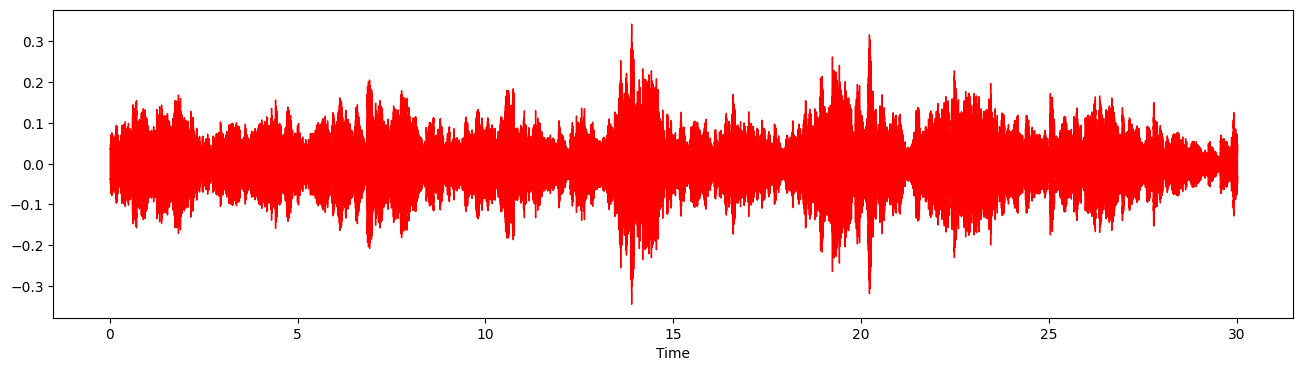

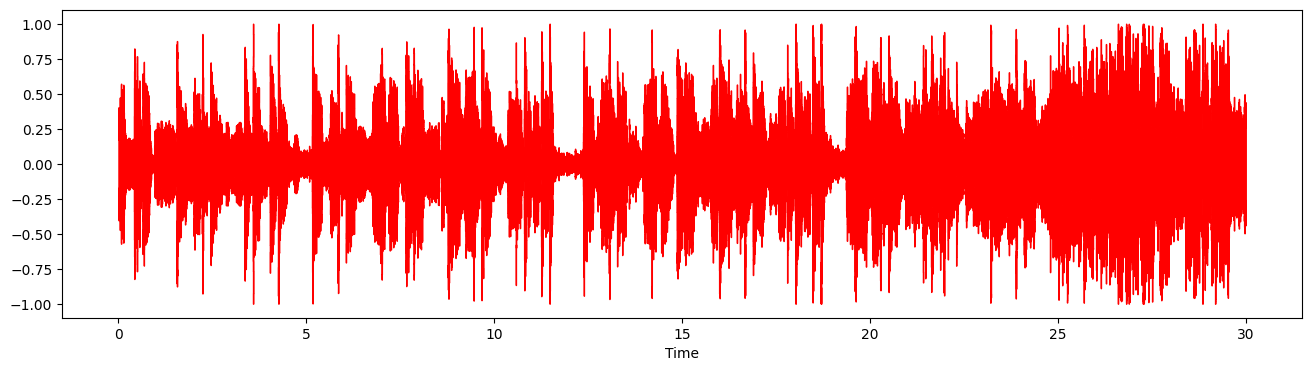

In [ ]:
# plotting raw wav

#classical
plt.figure(figsize = (16,4))
librosa.display.waveshow(aud_data1, color="Red")
plt.show()

#pop
plt.figure(figsize = (16,4))
librosa.display.waveshow(aud_data2, color="Red")
plt.show()

In [ ]:
print("Classical")
Audio(aud_data1, rate=sampling_rate1)

Classical


In [ ]:
print("Pop")
Audio(aud_data2, rate=sampling_rate2)

Pop


In [ ]:
gtzan_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
# Removing the filename row
gtzan_data = gtzan_data.drop(labels='filename', axis = 1)
gtzan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   length                   9990 non-null   int64  
 1   chroma_stft_mean         9990 non-null   float64
 2   chroma_stft_var          9990 non-null   float64
 3   rms_mean                 9990 non-null   float64
 4   rms_var                  9990 non-null   float64
 5   spectral_centroid_mean   9990 non-null   float64
 6   spectral_centroid_var    9990 non-null   float64
 7   spectral_bandwidth_mean  9990 non-null   float64
 8   spectral_bandwidth_var   9990 non-null   float64
 9   rolloff_mean             9990 non-null   float64
 10  rolloff_var              9990 non-null   float64
 11  zero_crossing_rate_mean  9990 non-null   float64
 12  zero_crossing_rate_var   9990 non-null   float64
 13  harmony_mean             9990 non-null   float64
 14  harmony_var             

***EXTRACTING & ALTERING FEATURES TO SUIT XGBoost***

In [ ]:
# using labelencoder to provide numeric labels to genre
class_list = gtzan_data.iloc[:, -1]
convertor = LabelEncoder()

y = convertor.fit_transform(class_list)

y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
from sklearn.preprocessing import StandardScaler

# normalizing data
fit = StandardScaler()
x = fit.fit_transform(np.array(gtzan_data.iloc[:, :-1], dtype = float))
x

array([[ 0.        , -0.48780784,  0.64052047, ..., -0.51356204,
         0.12841417, -0.29178072],
       [ 0.        , -0.40314187,  0.13183473, ...,  1.01138445,
         1.27578001,  0.05642464],
       [ 0.        , -0.36169428,  0.7644909 , ..., -0.04624405,
         0.65390663, -0.52145798],
       ...,
       [ 0.        , -0.35433044,  0.42997426, ..., -0.15370124,
         0.11765485, -0.33882395],
       [ 0.        ,  0.0883611 , -0.00630133, ..., -0.72456977,
         0.30333409, -0.95893743],
       [ 0.        , -0.11321002,  0.19536324, ..., -0.37245283,
        -0.47495901, -0.55112155]])

***SPLITTING DATASET INTO TRAINING AND TESTING DATA***

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size = 0.20)
print(len(y_train))
print(len(y_test))

7992
1998


***IMPLEMENTING XGBOOST***

In [ ]:
xgmodel = XGBClassifier(
     objective='multi:softmax',
     n_estimators=500,
     eval_metric='mlogloss',
     num_class=10,
     random_state=42,
)

xgmodel.fit(x_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=10, num_parallel_tree=None, ...)

***EVALUATING THE MODEL***

In [ ]:
from sklearn.metrics import accuracy_score

#make predictions
y_pred=xgmodel.predict(x_test)

#calculating accuracy
accuracy=accuracy_score(y_test,y_pred)
print(f'Test Accuracy: {accuracy:.5f}')

Test Accuracy: 0.91041


***IMPORTING THE MODEL***

In [ ]:
import joblib

xgmodel = joblib.load('/content/drive/MyDrive/music_genre_xgboost_model.pkl')

***KNN MODEL***

In [ ]:
import pandas as pd

# Load the dataset from the CSV file
csv_file_path = '/content/projects/Data/features_3_sec.csv'
data = pd.read_csv(csv_file_path)

# Preview the dataset
print(data.head())


            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

***Prepare the Features and Labels***

In [ ]:
# Assuming the label column is named 'label' or similar
X = data.drop(columns=['label'])  # Features
y = data['label']  # Labels

# If the label is categorical, encode it
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


***TRAIN THE KNN MODEL***

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(x_train, y_train)


KNeighborsClassifier()

***Evaluate the Model***

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = knn.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.88


***IMPORTING KNN MODEL***

In [ ]:
knn = joblib.load('/content/drive/MyDrive/music_genre_knn_model.pkl')

***ENSEMBLE MODEL USING SOFT VOTING***

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('knn', knn),
        ('xgb', xgmodel)
    ],
    voting='soft'
)

ensemble_model.fit(x_train, y_train)

y_pred_ensemble = ensemble_model.predict(x_test)


***EVALUATING THE ENSEMBLE MODEL***

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f'Ensemble Model Test Accuracy: {accuracy:.2f}')


Ensemble Model Test Accuracy: 0.94


***OUTPUT***

In [ ]:
input = x_test[0]
input = input.reshape(1, -1)

output = ensemble_model.predict(input)
output = label_encoder.inverse_transform(output)
print(output)

['disco']


***USING RANDOM FUNCTION***

In [ ]:
import random

rand  = random.randint(1,100)
input = x_test[rand]
input = input.reshape(1, -1)

output = ensemble_model.predict(input)
output = label_encoder.inverse_transform(output)
print(output)

['hiphop']
